In [4]:
import numpy as np
import matplotlib.pyplot as plt

from abses import MainModel, Actor
from abses.datacollection import DataCollector

# Initialize random number generator
rng = np.random.default_rng(42)

In [5]:
def plot_state(state: np.ndarray):
    cmap = plt.cm.colors.ListedColormap(["black", "red", "orange", "green"])
    norm = plt.cm.colors.BoundaryNorm([0, 0.5, 1, 1.5, 2], cmap.N)

    plt.imshow(state, cmap=cmap, norm=norm, interpolation="nearest")


class Tree(Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.state = "INTACT"

    @property
    def is_intact(self):
        return self.state == "INTACT"

    @property
    def is_burning(self):
        return self.state == "BURNING"

    @property
    def is_scorched(self):
        return self.state == "SCORCHED"

    def step(self):
        if self.state == "BURNING":
            for neighbor in self.model.nature.major_layer.iter_neighbors(
                self.pos, moore=False
            ):
                if neighbor.has_agent():
                    neighbor.agents.trigger("ignite")

            self.state = "SCORCHED"

    def ignite(self):
        if self.state == "INTACT":
            self.state = "BURNING"


class Forest(MainModel):
    def __init__(self, shape, density, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.shape = shape
        self.density = density
        self.num_trees = self.calc_num_trees()

        # Initialize a grid
        self.nature.create_module(how="from_resolution", shape=self.shape)

        # Create initial agents
        self.agents.create(Tree, self.num_trees)

        # Position the agents across the grid and \
        # set initial state 'burning' for leftmost trees
        positions = self.get_trees_pos()

        for i, tree in enumerate(self.actors):
            tree.put_on_layer(layer=self.nature.major_layer, pos=positions[i])

            if positions[i][1] == 0:
                tree.state = "BURNING"

        self.datacollector = DataCollector(
            self, model_reporters={"state": lambda m: m.get_state()}
        )

    def step(self):
        self.actors.trigger("step")
        self.datacollector.collect()

    def calc_num_trees(self):
        return int(self.shape[0] * self.shape[1] * self.density)

    def get_trees_pos(self):
        all_pos_ = [
            c.pos for row in self.nature.major_layer.cells for c in row
        ]
        return rng.choice(all_pos_, size=self.num_trees, replace=False)

    def get_state(self):
        state_ = np.zeros(self.shape)
        for tree in self.actors:
            if tree.is_burning:
                state_[tree.pos] = 0.5
            if tree.is_scorched:
                state_[tree.pos] = 1
            if tree.is_intact:
                state_[tree.pos] = 1.5

        return state_

In [13]:
parameters = {
    "time": {
        "end": 10,
    }
}

model = Forest(shape=(30, 30), density=0.8, parameters=parameters)

model.run_model()

[2024-02-04 09:05:08][human          ] | Initializing a new Human Module...
[2024-02-04 09:05:08][nature         ] | Initializing a new Base Nature module...
[2024-02-04 09:05:08][nature         ] | Initializing a new Model Layer...
[2024-02-04 09:05:08][nature         ] | Using rioxarray version: 0.13.4
[2024-02-04 09:05:08][container      ] | Created 720 actors of breed Tree


[2024-02-04 09:05:08][datacollection ] | DataCollector component initialized.
[2024-02-04 09:05:08][main           ] | Setting up Forest...
[2024-02-04 09:05:08][main           ] | Ending Forest


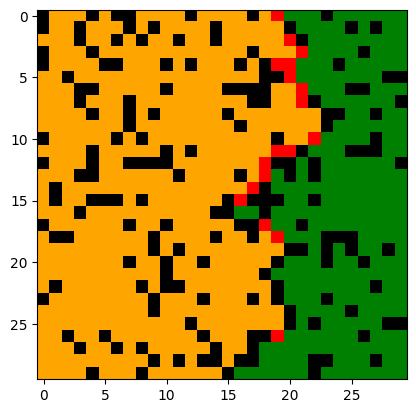

In [14]:
plot_state(model.get_state())